In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

In [9]:
publishedAt = []
title = []
viewCount = []
for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])

In [10]:
dict = {}
dict["publishedAt"] = publishedAt
dict["title"] = title
dict["viewCount"] = viewCount

In [11]:
import pandas as pd
df = pd.DataFrame.from_dict(dict)

In [12]:
df['viewCount'] = df['viewCount'].astype(int)

In [13]:
df.head()

,publishedAt,title,viewCount
0,2021-04-09T09:00:28Z,에이치엘비 뇌종양 항암효과 네이처지에 실렸다!,1645
1,2021-04-09T03:00:10Z,에이치엘비 증선위가 무증 효과를 지웠다!!,5564
2,2021-04-08T21:00:31Z,에이치엘비 베리스모 CAR-T 중국 시장 진출 본격화하면 현재 긴밀한 관계를 맺고 ...,4730
3,2021-04-08T08:00:09Z,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,6789
4,2021-04-08T01:34:11Z,에이치엘비 주주 오세훈 서울시장 당선!!,5929


In [14]:
len(df)

2594

# 제목에 '에이치엘비'가 없다면 Drop하기

In [15]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == True)]
len(df)

1448

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기

In [16]:
df['에이치엘비생명과학'] = df['title'].str.contains('에이치엘비생명과학')
df = df.loc[df['에이치엘비생명과학'] == False]
len(df)

1411

# 제목에 '에이치엘비제약'이 있다면 Drop하기

In [17]:
df['에이치엘비제약'] = df['title'].str.contains('에이치엘비제약')
df = df.loc[(df['에이치엘비제약'] == False)]
len(df)

1383

# 과거 절반 데이터 Drop하기

In [18]:
df_half = df.copy()
df_half = df_half[:int(len(df_half)/2)]
len(df_half)

691

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [19]:
df_half = df_half[5:]

In [20]:
len(df_half)

686

# 제목에 영어 있는 영상 구분하기

In [22]:
df_half.head()

,publishedAt,title,viewCount,에이치엘비,에이치엘비생명과학,에이치엘비제약
5,2021-04-07T21:00:15Z,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8238,True,False,False
6,2021-04-07T08:15:01Z,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7647,True,False,False
7,2021-04-07T03:00:11Z,에이치엘비가 뛰어든 CAR-T치료제의 부작용은 노바티스와 길리어드사이언스에서도 보이...,3187,True,False,False
8,2021-04-06T21:00:09Z,에이치엘비 CAR-T는 암환자 숫자의 90% 이상인 고형암을 공략하고 노바티스 CA...,5497,True,False,False
9,2021-04-06T12:14:22Z,에이치엘비 고통분담방송 2021년 4월 6일 화요일,6691,True,False,False


In [52]:
df_eng = df_half.copy()

match가 아닌 search를 사용한 이유는 문자열 처음부터 정규식과 매치되는지 조사하는 것이 아니라 문자열 전체를 검색하여 정규식과 매치되는지 조사하는 것이기 때문이다.  
참고 링크 : https://wikidocs.net/4308

In [53]:
import re
def reg_func(word):
    if re.compile('[a-zA-Z]+').search(word):
        return True
    else:
        return False

In [54]:
df_eng['english'] = df_eng['title'].apply(reg_func)

In [55]:
df_eng.head()

,publishedAt,title,viewCount,에이치엘비,에이치엘비생명과학,에이치엘비제약,english
5,2021-04-07T21:00:15Z,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8238,True,False,False,False
6,2021-04-07T08:15:01Z,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7647,True,False,False,False
7,2021-04-07T03:00:11Z,에이치엘비가 뛰어든 CAR-T치료제의 부작용은 노바티스와 길리어드사이언스에서도 보이...,3187,True,False,False,True
8,2021-04-06T21:00:09Z,에이치엘비 CAR-T는 암환자 숫자의 90% 이상인 고형암을 공략하고 노바티스 CA...,5497,True,False,False,True
9,2021-04-06T12:14:22Z,에이치엘비 고통분담방송 2021년 4월 6일 화요일,6691,True,False,False,False


In [57]:
df_eng.groupby('english').viewCount.mean()

english
False    8288.761236
True     7070.845455
Name: viewCount, dtype: float64

영어가 포함된 제목은 True다. 한글만 있는 제목은 False다.

In [60]:
df_eng.groupby('english').viewCount.size()

english
False    356
True     330
Name: viewCount, dtype: int64

sample 개수는 비슷하다.

# t-test하기

In [64]:
from scipy.stats import ttest_ind
english = df_eng.loc[df_eng['english'] == True].viewCount
hangul = df_eng.loc[df_eng['english'] == False].viewCount

In [65]:
len(english)

330

In [66]:
len(hangul)

356

array로 t-test한다.

In [67]:
ttest_ind(english, hangul)

Ttest_indResult(statistic=-3.141486325454457, pvalue=0.0017534264611294545)

list로 t-test 한 번 더 한다. 같은 결과다.

In [68]:
english = list(english)
hangul = list(hangul)

In [69]:
ttest_ind(english, hangul)

Ttest_indResult(statistic=-3.141486325454457, pvalue=0.0017534264611294545)

# barchart

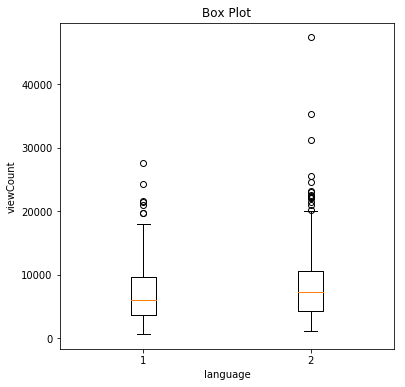

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 6))
plt.grid()
plt.boxplot([english, hangul])
plt.xlabel('language')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
영어가 포함된 제목의 330개 영상 평균 조회수는 7070회  
한글만 포함된 제목의 356개 영상 평균 조회수는 8288회  
(p=0.0017)

# Conclusion
한글만 사용한다.